## Initial Setup

### Import necessary libraries

In [5]:
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# # Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score


import os
from scipy.fft import fft, fftfreq
from scipy.signal import welch, spectrogram 
from rpca import RPCA

### Decompress the .mat files if it is compressed And Load Them

Following subject data and its quality:
- `S1.mat` $\rightarrow$ good subject data
- `S3.mat` $\rightarrow$ good subject data
- `S31.mat` $\rightarrow$ good subject data
- `S32.mat` $\rightarrow$ good subject data
- `S19.mat` $\rightarrow$ medium subject data
- `S29.mat` $\rightarrow$ bad subject data

In [6]:
NUM_SUBJECTS = 1
eeg_data_by_subject = np.empty((NUM_SUBJECTS, 64, 1500, 40, 6))

for subject in range(1, NUM_SUBJECTS+1):
    # Path to the compressed file
    compressed_file = f'./data/S{subject}.mat.7z'
    mat_file = f'./data/S{subject}.mat'

    # Check if the .mat file already exists
    if os.path.exists(mat_file):
        print(f"Using existing file {mat_file}")
    # Check if the compressed file exists
    elif os.path.exists(compressed_file):
        # Extract the file
        with py7zr.SevenZipFile(compressed_file, mode='r') as z:
            z.extractall()
        print(f"Successfully extracted {compressed_file}")
    else:
        print(f"File {compressed_file} not found")

    eeg_data_by_subject[subject - 1] = np.array(sio.loadmat(mat_file)['data'])


Using existing file ./data/S1.mat


### Define useful global variables

In [7]:
frequency_to_index = {
    8: 0, 9: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6, 15: 7,
    8.2: 8, 9.2: 9, 10.2: 10, 11.2: 11, 12.2: 12, 13.2: 13, 14.2: 14, 15.2: 15,
    8.4: 16, 9.4: 17, 10.4: 18, 11.4: 19, 12.4: 20, 13.4: 21, 14.4: 22, 15.4: 23,
    8.6: 24, 9.6: 25, 10.6: 26, 11.6: 27, 12.6: 28, 13.6: 29, 14.6: 30, 15.6: 31,
    8.8: 32, 9.8: 33, 10.8: 34, 11.8: 35, 12.8: 36, 13.8: 37, 14.8: 38, 15.8: 39,
}

samples = 250 # 250 samples analyzed at once
spacing = 4  # time between samples in ms
fs = 250  # 250 Hz sampling rate


time_range = np.linspace(0, samples * spacing, samples)
freq_range = fftfreq(samples, spacing)[: samples // 2] * 1000
default_freq_xlim = [5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35]

# Define all available channels with their corresponding indices
relevant_channels = {
    ### Secondary electrodes
    "FCz":18,
    "C5": 24,
    "C3": 25,
    "C1": 26,
    "C2": 28,
    "C4": 29,
    "C6": 30,
    "CPz": 37,
    "P7": 43,
    "P5": 44,
    "P3": 45,
    "P1": 46,
    "P2": 48,
    "P4": 49,
    "P6": 50,
    "P8": 51,

    ### Best electrodes
    ## Frontal
    "Cz": 27,
    
    ## Parietal
    "Pz": 47,
    
    ## Parieto-occipital
    "PO7": 52,
    "PO5": 53,
    "PO3": 54,
    
    "POz": 55,

    "PO4": 56,
    "PO6": 57,
    "PO8": 58,

    ## Occipital
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}

# Electrode sets with number of electrodes as key and channel name/index dict as value
channels_sets = {
    1:  {ch: relevant_channels[ch] for ch in ["Oz"]},
    4:  {ch: relevant_channels[ch] for ch in ["POz", "O1", "Oz", "O2"]},
    8:  {ch: relevant_channels[ch] for ch in ["PO5", "PO3", "POz", "PO4", "PO6", "O1", "Oz", "O2"]},
    9:  {ch: relevant_channels[ch] for ch in ["Pz", "PO5", "PO3", "POz", "PO4", "PO6", "O1", "Oz", "O2"]},
    12: {ch: relevant_channels[ch] for ch in ["Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    14: {ch: relevant_channels[ch] for ch in ["P3", "P4", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    16: {ch: relevant_channels[ch] for ch in ["P3", "P1", "P2", "P4", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    18: {ch: relevant_channels[ch] for ch in ["P5", "P3", "P1", "P2", "P4", "P6", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    20: {ch: relevant_channels[ch] for ch in ["P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    22: {ch: relevant_channels[ch] for ch in ["FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    24: {ch: relevant_channels[ch] for ch in ["C1", "C2", "FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    26: {ch: relevant_channels[ch] for ch in ["C3", "C4", "C1", "C2", "FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    28: {ch: relevant_channels[ch] for ch in ["C5", "C6", "C3", "C4", "C1", "C2", "FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
}

selected_channels = channels_sets[9]

most_relevant_channels = {
    # "Pz": 47,
    # "POz": 55,
    # For most individuals
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}

# preprocessing_methods list
preprocessing_methods = ["CAR", "RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]

# variables used for BCI experiments
evoked_frequencies = [8, 10, 12, 15] # frequencies to be used for the BCI experiment (in Hz)
default_evoked_frequency = 8
number_of_windows = 5 # number of windows to split into the useful trial interval (1 second segments along 5 seconds per trial)
number_of_trials = eeg_data_by_subject[0].shape[3] # number of trials to use for the BCI experiment
bci_start_sample = 125 # the first 0.5 seconds are discarded
bci_end_sample = 1375 # the last 0.5 seconds are discarded

### Define useful functions

#### Pre-processing

In [8]:
## CAR
def apply_car_filter(eeg_data):
    """
    Apply Common Average Reference (CAR) filtering to EEG data.
    
    CAR subtracts the average of all electrodes from each individual electrode:
    V_i^CAR = V_i^EL - (1/n) * sum(V_j^EL) for all j electrodes
    
    Parameters:
    -----------
    eeg_data : numpy.ndarray
        Input EEG data with shape (channels, samples, frequencies, trials) or (channels, samples) or (trials, channels, samples)
        
    Returns:
    --------
    car_filtered : numpy.ndarray
        CAR-filtered EEG data with the same shape as the input
    """
    
    # Make a copy to avoid modifying the original data
    car_filtered = eeg_data.copy()
    
    # Determine if we have multiple multiple dimensions
    if len(eeg_data.shape) == 4:  # (channels, samples, frequencies, trials)
        n_of_trials = eeg_data.shape[3]
        n_of_frequencies = eeg_data.shape[2]
        # Calculate mean across channels for each trial
        for trial in range(n_of_trials):
            for freq in range(n_of_frequencies):
                channel_mean = np.mean(eeg_data[:, :, freq, trial], axis=0)
                car_filtered[:, :, freq, trial] = eeg_data[:, :, freq, trial] - channel_mean

    elif len(eeg_data.shape) == 3:  # (trials, channels, samples)
        # Calculate mean across channels for each trial
        channel_mean = np.mean(eeg_data, axis=1, keepdims=True)
        # Subtract mean from each channel
        car_filtered = eeg_data - channel_mean

    else:  # (channels, samples)
        # Calculate mean across channels
        channel_mean = np.mean(eeg_data, axis=0, keepdims=True)
        # Subtract mean from each channel
        car_filtered = eeg_data - channel_mean
    
    return car_filtered

#### Feature Extraction

In [9]:
## Feature extraction
def get_label_vector(evoked_frequencies):
    Y = np.zeros(number_of_windows * number_of_trials * len(evoked_frequencies), int)

    for i, frequency in enumerate(evoked_frequencies):
        for j in range(number_of_trials):
            for k in range(number_of_windows):
                Y[i * number_of_trials * number_of_windows + j * number_of_windows + k] += i

    return Y

def get_label_matrix(evoked_frequencies):
    Y = np.ones((number_of_windows * number_of_trials * len(evoked_frequencies), len(evoked_frequencies)), int)

    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if int(i / (number_of_windows * number_of_trials)) != j:
                Y[i, j] *= -1

    return Y

def get_feature_matrix_from_eeg_frequency_domain(spectogram_data_by_channel_trial_and_frequency, spectogram_frequencies, evoked_frequencies, selected_channels, start_sample, end_sample, select_first_harmonic=False):
    
    # Building X matrix
    number_of_frequencies = len(evoked_frequencies) * (2 if select_first_harmonic else 1)

    X = np.array([np.zeros(len(selected_channels) * number_of_frequencies)])

    frequency_values_to_select = evoked_frequencies
    if select_first_harmonic: # append the first harmonic if needed
        frequency_values_to_select = np.hstack(
            (frequency_values_to_select, np.array(frequency_values_to_select) * 2)
        )

    for i, evoked_frequency in enumerate(evoked_frequencies):

        for j in range(number_of_trials):

            for k in range(number_of_windows):
                temp = np.array([])

                for channel_name in selected_channels.keys():

                    channel_power_points = np.array([])
                    for i, frequency in enumerate(spectogram_frequencies):
                        if frequency not in frequency_values_to_select:
                            continue

                        channel_power_points = np.hstack((
                            channel_power_points,
                            spectogram_data_by_channel_trial_and_frequency[evoked_frequency][j][channel_name][i, k]
                        ))

                    temp = np.hstack((temp, np.array(channel_power_points)))
                X = np.vstack((X, temp))

    # Drop the first line
    X = X[1:, :]

    print('Feature Matrix:', X.shape)

    return X

In [10]:
## OPTIMIZED SPECTROGRAM SYSTEM
# Global cache for precomputed spectrograms
# Structure: cache[trial][frequency][channel_name] = (freqs, flattened_spectrogram)
_spectrogram_cache = {}
_cache_initialized = False

def precompute_all_spectrograms(eeg_data, selected_channels, evoked_frequencies, fs, 
                               start_sample, end_sample, select_first_harmonic=True, nperseg=250):
    """
    Precompute all spectrograms for all trials, frequencies, and channels.
    This eliminates redundant spectrogram calculations in subsequent processing.
    
    Args:
        eeg_data: EEG data array with shape (channels, samples, frequencies, trials)
        selected_channels: Dictionary of selected channels {name: index}
        evoked_frequencies: List of evoked frequencies in Hz
        fs: Sampling frequency
        start_sample: Starting sample index
        end_sample: Ending sample index
        nperseg: Segment length for spectrogram
        
    Returns:
        None (stores results in global cache)
    """
    global _spectrogram_cache, _cache_initialized
    
    print("Precomputing spectrograms for optimization...")
    _spectrogram_cache = {}
    
    num_trials = eeg_data.shape[3]
    total_operations = num_trials * len(evoked_frequencies) * len(selected_channels)
    current_op = 0
    
    for trial in range(num_trials):
        _spectrogram_cache[trial] = {}
        
        for frequency in evoked_frequencies:
            frequency_index = frequency_to_index[frequency]
            _spectrogram_cache[trial][frequency] = {}
            
            for channel_name, channel_index in selected_channels.items():
                # Extract channel data for this trial and frequency
                channel_eeg_data = eeg_data[channel_index, start_sample:end_sample, frequency_index, trial]
                
                # Compute spectrogram
                freqs, t, Sxx = spectrogram(channel_eeg_data, fs=fs, nperseg=nperseg)
                
                # Apply frequency range filtering (6-32 Hz)
                freq_range_mask = (freqs >= 6) & (freqs <= 32)
                freqs_filtered = freqs[freq_range_mask]
                Sxx_filtered = Sxx[freq_range_mask, :]
                
                # Store flattened spectrogram for direct use in RPCA
                _spectrogram_cache[trial][frequency][channel_name] = {
                    'freqs': freqs_filtered,
                    'time': t,
                    'spectrogram_flat': Sxx_filtered.flatten(),
                    'spectrogram_shape': Sxx_filtered.shape
                }
                
                current_op += 1
                if current_op % 100 == 0 or current_op == total_operations:
                    print(f"Progress: {current_op}/{total_operations} spectrograms computed ({100*current_op/total_operations:.1f}%)")
    
    _cache_initialized = True
    print(f"✓ Spectrogram cache initialized with {total_operations} precomputed spectrograms")
    print(f"Cache structure: {num_trials} trials × {len(evoked_frequencies)} frequencies × {len(selected_channels)} channels")

def get_cached_spectrogram(trial, frequency, channel_name):
    """
    Retrieve a precomputed spectrogram from the global cache.
    
    Args:
        trial: Trial index
        frequency: Evoked frequency in Hz
        channel_name: Name of the channel
        
    Returns:
        Dictionary with 'freqs', 'time', 'spectrogram_flat', 'spectrogram_shape'
    """
    global _spectrogram_cache, _cache_initialized
    
    if not _cache_initialized:
        raise RuntimeError("Spectrogram cache not initialized. Call precompute_all_spectrograms() first.")
    
    try:
        return _spectrogram_cache[trial][frequency][channel_name]
    except KeyError as e:
        raise KeyError(f"Spectrogram not found in cache for trial={trial}, frequency={frequency}, channel={channel_name}") from e

def clear_spectrogram_cache():
    """Clear the spectrogram cache to free memory."""
    global _spectrogram_cache, _cache_initialized
    _spectrogram_cache = {}
    _cache_initialized = False
    print("✓ Spectrogram cache cleared")

def get_cache_info():
    """Get information about the current cache state."""
    global _spectrogram_cache, _cache_initialized
    
    if not _cache_initialized:
        return "Cache not initialized"
    
    num_trials = len(_spectrogram_cache)
    if num_trials > 0:
        num_frequencies = len(next(iter(_spectrogram_cache.values())))
        if num_frequencies > 0:
            num_channels = len(next(iter(next(iter(_spectrogram_cache.values())).values())))
            return f"Cache contains: {num_trials} trials × {num_frequencies} frequencies × {num_channels} channels = {num_trials * num_frequencies * num_channels} spectrograms"
    return "Cache is empty"


In [11]:
## OPTIMIZED RPCA Spectogram (USES PRECOMPUTED CACHE)
def get_spectogram_data_rpca_filtered_optimized(eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
                                     lambda_val, mu_val, nperseg=250, filter_type='L'):
    """
    [OPTIMIZED VERSION] Compute the Spectrogram and apply RPCA filtering for all trials, organized by evoked frequencies.
    This version uses precomputed spectrograms for significant performance improvement.
    
    Args:
        eeg_data: EEG data array
        selected_channels: Dictionary of selected channels
        evoked_frequencies: List of evoked frequencies in Hz
        fs: Sampling frequency
        start_sample: Starting sample index
        end_sample: Ending sample index
        lambda_val: RPCA lambda parameter
        mu_val: RPCA mu parameter
        nperseg: Segment length for spectrogram
        filter_type: 'L' for low-rank component, 'S' for sparse component
        
    Returns:
        freqs: Frequency array
        t: Time array
        trial_spectrograms_by_frequency: Dictionary of evoked frequencies as keys and RPCA-filtered components for each trial as values
    """
    global _cache_initialized
    
    # Check if cache is available
    if not _cache_initialized:
        print("⚠️  Cache not initialized. Falling back to original computation.")
        print("💡 Call precompute_all_spectrograms(eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample) first for optimal performance.")
        return get_spectogram_data_rpca_filtered(
            eeg_data, selected_channels, evoked_frequencies, fs, 
            start_sample, end_sample, lambda_val, mu_val, nperseg, filter_type
        )
    
    trial_spectrograms_by_frequency = {freq: [] for freq in evoked_frequencies}

    print(f"🚀 Using optimized cached spectrograms (Performance boost expected!)")
    print(f"Selected channels: {selected_channels}")

    # Iterate over all trials
    num_trials = eeg_data.shape[3]
    
    # Get sample frequency and time data from first cached spectrogram
    first_cached = get_cached_spectrogram(0, evoked_frequencies[0], list(selected_channels.keys())[0])
    freqs = first_cached['freqs']
    t = first_cached['time']
    sample_shape = first_cached['spectrogram_shape']
    
    for trial in range(num_trials):
        for frequency in evoked_frequencies:
            # Get precomputed spectrograms for all channels for this trial and frequency
            channel_linearized_data = []
            
            for channel_name in selected_channels.keys():
                try:
                    cached_data = get_cached_spectrogram(trial, frequency, channel_name)
                    channel_linearized_data.append(cached_data['spectrogram_flat'])
                except KeyError as e:
                    print(f"⚠️  Cache miss for trial={trial}, freq={frequency}, channel={channel_name}")
                    print("Falling back to on-the-fly computation for this spectrogram")
                    
                    # Fallback: compute spectrogram on-the-fly
                    channel_index = selected_channels[channel_name]
                    frequency_index = frequency_to_index[frequency]
                    channel_eeg_data = eeg_data[channel_index, start_sample:end_sample, frequency_index, trial]
                    
                    freqs_temp, t_temp, Sxx_temp = spectrogram(channel_eeg_data, fs=fs, nperseg=nperseg)
                    freq_range_mask = (freqs_temp >= 6) & (freqs_temp <= 32)
                    Sxx_temp = Sxx_temp[freq_range_mask, :]
                    
                    channel_linearized_data.append(Sxx_temp.flatten())
            
            # Stack all linearized data for the current trial
            channel_linearized_data = np.array(channel_linearized_data)
            
            # Apply RPCA filtering to the spectrogram
            try:
                L_spectogram, S_spectogram = RPCA(channel_linearized_data, lambda_val, mu_val, tolerance=10e-4, max_iteration=1000)
                
                if filter_type == 'L':
                    Sxx_filtered = L_spectogram
                elif filter_type == 'S':
                    Sxx_filtered = S_spectogram
                else:
                    raise ValueError("filter_type must be 'L' or 'S'")

                # Unflatten the data
                Sxx_filtered_by_channel = {}
                for i, channel_name in enumerate(selected_channels.keys()):
                    Sxx_filtered_by_channel[channel_name] = Sxx_filtered[i, :].reshape(sample_shape)

                trial_spectrograms_by_frequency[frequency].append(Sxx_filtered_by_channel)

            except Exception as e:
                print(f"RPCA filtering failed for trial {trial + 1}: {e}")
                print("Returning original spectrogram for this trial")
                trial_spectrograms_by_frequency[frequency].append(channel_linearized_data)

    return freqs, t, trial_spectrograms_by_frequency

# For backwards compatibility, you can replace the original function
# Uncomment the line below to use the optimized version by default:
get_spectogram_data_rpca_filtered = get_spectogram_data_rpca_filtered_optimized


#### Models

In [12]:
class LeastSquares:
    def __init__(self):
        self.W = None

    def fit(self, X, Y):
        X_plus_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1) # add bias
        
        self.W = np.matmul(np.linalg.pinv(X_plus_bias), Y)

    def predict(self, X):
        X_plus_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)  # add bias

        predictions = np.matmul(X_plus_bias, self.W)
        
        return np.argmax(predictions, axis=1)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

#### Utils

In [33]:
## Spectogram
def get_spectogram_data(eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, nperseg=250):
    """
    Compute the Spectogram using Welch's method for all trials and organize by evoked frequencies.
    
    Args:
        eeg_data: EEG data array
        selected_channels: Dictionary of selected channels
        evoked_frequencies: List of evoked frequencies in Hz
        fs: Sampling frequency
        start_sample: Starting sample index
        end_sample: Ending sample index
        nperseg: Segment length for spectrogram
        
    Returns:
        freqs: Frequency array
        t: Time array
        trial_spectrograms_by_frequency: Dictionary of evoked frequencies as keys and spectrogram data for each trial as values
    """
    trial_spectrograms_by_frequency = {freq: [] for freq in evoked_frequencies}

    # Get the indexes of selected channels
    print(f"Selected channels: {selected_channels}")
    print(f"Selected channels values: {selected_channels.values()}")

    # Iterate over all trials
    num_trials = eeg_data.shape[3]
    for trial in range(num_trials):
        for frequency in evoked_frequencies:
            frequency_index = frequency_to_index[frequency]
            # Initialize a dictionary to store spectrogram data for each channel
            Sxx_by_channel = {}

            for channel_name, channel_index in selected_channels.items():
                channel_eeg_data = eeg_data[channel_index, start_sample:end_sample, frequency_index, trial]
                
                # Use spectrogram function from scipy
                freqs, t, Sxx = spectrogram(channel_eeg_data, fs=fs, nperseg=nperseg)

                # Normalize the spectrogram
                Sxx_normalized = Sxx / np.max(Sxx)

                # Select the frequency range
                freq_range_mask = (freqs >= 6) & (freqs <= 32)
                freqs = freqs[freq_range_mask]
                Sxx_normalized = Sxx_normalized[freq_range_mask, :]

                Sxx_by_channel[channel_name] = Sxx_normalized
                print(f"Sxx_by_channel shape for trial {trial + 1}, channel {channel_name}: {Sxx_by_channel[channel_name].shape}")

            trial_spectrograms_by_frequency[frequency].append(Sxx_by_channel)

    return freqs, t, trial_spectrograms_by_frequency

def plot_spectrogram_comparison(eeg_data, channel_name, selected_channels, trial, frequency, fs, start_sample, end_sample,
                                lambda_val, mu_val, nperseg=250, subject_id=None):
    """
    Plot comparison of 4 spectrogram filtering methods: Original, CAR, RPCA-L, RPCA-S
    
    Args:
        eeg_data: EEG data array
        channel_name: Name of the channel to analyze
        selected_channels: Dictionary of selected channels
        trial: Trial number (1-indexed)
        frequency: Frequency value in Hz
        fs: Sampling frequency
        start_sample: Starting sample index
        end_sample: Ending sample index
        lambda_val: RPCA lambda parameter
        mu_val: RPCA mu parameter
        nperseg: Segment length for spectrogram
        subject_id: Subject identifier for titles
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    # 1. Original spectrogram
    freqs1, t1, trial_spectrograms1 = get_spectogram_data(
        eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, nperseg
    )
    im1 = axes[0].pcolormesh(t1, freqs1, trial_spectrograms1[frequency][trial - 1][channel_name])
    axes[0].set_title(f"Original - Trial {trial} - {channel_name}")
    axes[0].set_ylabel('Frequency [Hz]')
    axes[0].set_xlabel('Time [sec]')
    plt.colorbar(im1, ax=axes[0])
    
    # 2. CAR filtered spectrogram
    freqs2, t2, trial_spectrograms2 = get_spectogram_data(
        apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, start_sample, end_sample, nperseg
    )
    im2 = axes[1].pcolormesh(t2, freqs2, trial_spectrograms2[frequency][trial - 1][channel_name])
    axes[1].set_title(f"CAR Filtered - Trial {trial} - {channel_name}")
    axes[1].set_ylabel('Frequency [Hz]')
    axes[1].set_xlabel('Time [sec]')
    plt.colorbar(im2, ax=axes[1])
    
    # 3. RPCA L component spectrogram
    freqs3, t3, trial_spectrograms3 = get_spectogram_data_rpca_filtered(
        eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
        lambda_val, mu_val, nperseg, filter_type='L'
    )
    im3 = axes[2].pcolormesh(t3, freqs3, trial_spectrograms3[frequency][trial - 1][channel_name])
    axes[2].set_title(f"RPCA-L Filtered - Trial {trial} - {channel_name}")
    axes[2].set_ylabel('Frequency [Hz]')
    axes[2].set_xlabel('Time [sec]')
    plt.colorbar(im3, ax=axes[2])
    
    # 4. RPCA S component spectrogram
    freqs4, t4, trial_spectrograms4 = get_spectogram_data_rpca_filtered(
        eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
        lambda_val, mu_val, nperseg, filter_type='S'
    )
    im4 = axes[3].pcolormesh(t4, freqs4, trial_spectrograms4[frequency][trial - 1][channel_name])
    axes[3].set_title(f"RPCA-S Filtered - Trial {trial} - {channel_name}")
    axes[3].set_ylabel('Frequency [Hz]')
    axes[3].set_xlabel('Time [sec]')
    plt.colorbar(im4, ax=axes[3])
    
    # 5. CAR + RPCA L component spectrogram
    freqs5, t5, trial_spectrograms5 = get_spectogram_data_rpca_filtered(
        apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
        lambda_val, mu_val, nperseg, filter_type='L'
    )
    im5 = axes[4].pcolormesh(t5, freqs5, trial_spectrograms5[frequency][trial - 1][channel_name])
    axes[4].set_title(f"CAR + RPCA-L Filtered - Trial {trial} - {channel_name}")
    axes[4].set_ylabel('Frequency [Hz]')
    axes[4].set_xlabel('Time [sec]')
    plt.colorbar(im5, ax=axes[4])
    
    # 6. CAR + RPCA S component spectrogram
    freqs6, t6, trial_spectrograms6 = get_spectogram_data_rpca_filtered(
        apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
        lambda_val, mu_val, nperseg, filter_type='S'
    )
    im6 = axes[5].pcolormesh(t6, freqs6, trial_spectrograms6[frequency][trial - 1][channel_name])
    axes[5].set_title(f"CAR + RPCA-S Filtered - Trial {trial} - {channel_name}")
    axes[5].set_ylabel('Frequency [Hz]')
    axes[5].set_xlabel('Time [sec]')
    plt.colorbar(im6, ax=axes[5])
    
    # Add overall title
    subject_str = f"Subject {subject_id}"
    fig.suptitle(f"{subject_str} - Frequency {frequency} Hz - RPCA channels: {list(selected_channels.keys())} - RPCA Parameters Miximized for RPCA-S Accuracy", fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes


In [14]:
def plot_accuracy_boxplot(ls_accuracies, lda_accuracies, svm_accuracies, methods, indices, group_name, filename, selected_channels):
    """
    Plots and saves a boxplot of accuracies for the given group of patients.

    Args:
        ls_accuracies (dict): Least Squares accuracies per method.
        lda_accuracies (dict): LDA accuracies per method.
        svm_accuracies (dict): SVM accuracies per method.
        methods (list): List of preprocessing method names.
        indices (list or None): Indices of patients to include (None for all).
        group_name (str): Name of the group for the plot title.
        filename (str): Filename to save the plot.
        selected_channels (list): List of selected channels (for title).
    """
    plt.figure(figsize=(14, 8))
    data = []
    labels = []
    for method in methods:
        if indices is None:
            data.append(ls_accuracies[method])
            data.append(lda_accuracies[method])
            data.append(svm_accuracies[method])
        else:
            data.append(np.array(ls_accuracies[method])[indices])
            data.append(np.array(lda_accuracies[method])[indices])
            data.append(np.array(svm_accuracies[method])[indices])
        labels.append(f"{method}-LS")
        labels.append(f"{method}-LDA")
        labels.append(f"{method}-SVM")
    plt.boxplot(data, labels=labels, patch_artist=True)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.title(f'Distribution of Accuracies Across Subjects ({group_name}, {len(selected_channels)} channels)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

def load_subject_eeg_data(subject):
    """
    Load EEG data for a specific subject from a .mat file.
    
    This function checks if the .mat file already exists. If not, it attempts to extract
    the file from a compressed .7z archive. If neither file exists, it prints an error message.
    
    Args:
        subject: The subject identifier (used to construct filenames)
        
    Returns:
        The EEG data loaded from the .mat file, specifically the 'data' field
        
    Raises:
        FileNotFoundError: Implicitly if the .mat file doesn't exist after extraction attempt
    """
    # Path to the compressed file
    compressed_file = f'./data/S{subject}.mat.7z'
    mat_file = f'./data/S{subject}.mat'

    # Check if the .mat file already exists
    if os.path.exists(mat_file):
        print(f"Using existing file {mat_file}")
    # Check if the compressed file exists
    elif os.path.exists(compressed_file):
        # Extract the file
        with py7zr.SevenZipFile(compressed_file, mode='r') as z:
            z.extractall()
        print(f"Successfully extracted {compressed_file}")
    else:
        print(f"File {compressed_file} not found")

    return sio.loadmat(mat_file)['data']

def plot_spectrogram_comparison(eeg_data, channel_name, selected_channels, trial, frequency, fs, start_sample, end_sample,
                                lambda_val, mu_val, nperseg=250, subject_id=None):
    """
    Plot comparison of 4 spectrogram filtering methods: Original, CAR, RPCA-L, RPCA-S
    
    Args:
        eeg_data: EEG data array
        channel_name: Name of the channel to analyze
        selected_channels: Dictionary of selected channels
        trial: Trial number (1-indexed)
        frequency: Frequency value in Hz
        fs: Sampling frequency
        start_sample: Starting sample index
        end_sample: Ending sample index
        lambda_val: RPCA lambda parameter
        mu_val: RPCA mu parameter
        nperseg: Segment length for spectrogram
        subject_id: Subject identifier for titles
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    # 1. Original spectrogram
    freqs1, t1, trial_spectrograms1 = get_spectogram_data(
        eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, nperseg
    )
    im1 = axes[0].pcolormesh(t1, freqs1, trial_spectrograms1[frequency][trial - 1][channel_name])
    axes[0].set_title(f"Original - Trial {trial} - {channel_name}")
    axes[0].set_ylabel('Frequency [Hz]')
    axes[0].set_xlabel('Time [sec]')
    plt.colorbar(im1, ax=axes[0])
    
    # 2. CAR filtered spectrogram
    freqs2, t2, trial_spectrograms2 = get_spectogram_data(
        apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, start_sample, end_sample, nperseg
    )
    im2 = axes[1].pcolormesh(t2, freqs2, trial_spectrograms2[frequency][trial - 1][channel_name])
    axes[1].set_title(f"CAR Filtered - Trial {trial} - {channel_name}")
    axes[1].set_ylabel('Frequency [Hz]')
    axes[1].set_xlabel('Time [sec]')
    plt.colorbar(im2, ax=axes[1])
    
    # 3. RPCA L component spectrogram
    freqs3, t3, trial_spectrograms3 = get_spectogram_data_rpca_filtered(
        eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
        lambda_val, mu_val, nperseg, filter_type='L'
    )
    im3 = axes[2].pcolormesh(t3, freqs3, trial_spectrograms3[frequency][trial - 1][channel_name])
    axes[2].set_title(f"RPCA-L Filtered - Trial {trial} - {channel_name}")
    axes[2].set_ylabel('Frequency [Hz]')
    axes[2].set_xlabel('Time [sec]')
    plt.colorbar(im3, ax=axes[2])
    
    # 4. RPCA S component spectrogram
    freqs4, t4, trial_spectrograms4 = get_spectogram_data_rpca_filtered(
        eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
        lambda_val, mu_val, nperseg, filter_type='S'
    )
    im4 = axes[3].pcolormesh(t4, freqs4, trial_spectrograms4[frequency][trial - 1][channel_name])
    axes[3].set_title(f"RPCA-S Filtered - Trial {trial} - {channel_name}")
    axes[3].set_ylabel('Frequency [Hz]')
    axes[3].set_xlabel('Time [sec]')
    plt.colorbar(im4, ax=axes[3])
    
    # 5. CAR + RPCA L component spectrogram
    freqs5, t5, trial_spectrograms5 = get_spectogram_data_rpca_filtered(
        apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
        lambda_val, mu_val, nperseg, filter_type='L'
    )
    im5 = axes[4].pcolormesh(t5, freqs5, trial_spectrograms5[frequency][trial - 1][channel_name])
    axes[4].set_title(f"CAR + RPCA-L Filtered - Trial {trial} - {channel_name}")
    axes[4].set_ylabel('Frequency [Hz]')
    axes[4].set_xlabel('Time [sec]')
    plt.colorbar(im5, ax=axes[4])
    
    # 6. CAR + RPCA S component spectrogram
    freqs6, t6, trial_spectrograms6 = get_spectogram_data_rpca_filtered(
        apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
        lambda_val, mu_val, nperseg, filter_type='S'
    )
    im6 = axes[5].pcolormesh(t6, freqs6, trial_spectrograms6[frequency][trial - 1][channel_name])
    axes[5].set_title(f"CAR + RPCA-S Filtered - Trial {trial} - {channel_name}")
    axes[5].set_ylabel('Frequency [Hz]')
    axes[5].set_xlabel('Time [sec]')
    plt.colorbar(im6, ax=axes[5])
    
    # Add overall title
    subject_str = f"Subject {subject_id}"
    fig.suptitle(f"{subject_str} - Frequency {frequency} Hz - RPCA channels: {list(selected_channels.keys())} - RPCA Parameters: λ={lambda_val:.6f}, μ={mu_val:.6f}", fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes


## RPCA Parameter Optimization for Spectrogram Data

In [15]:
# Define parameter ranges for RPCA optimization on spectrogram data
# Using spectrogram dimensions to calculate base lambda
channel_name = "Oz"
freqs, t, Sxx = get_spectogram_data(
    eeg_data_by_subject[0],
    selected_channels,
    evoked_frequencies,
    fs=fs,
    start_sample=bci_start_sample,
    end_sample=bci_end_sample
)

# Base lambda calculated from spectrogram matrix dimensions
lamb_zero_spectogram = 1 / np.sqrt(max(Sxx[default_evoked_frequency][0][channel_name].shape))
mu_denominators = [1/10, 1, 2]

lamb_values_spectogram = [20 * lamb_zero_spectogram, 5 * lamb_zero_spectogram, lamb_zero_spectogram, lamb_zero_spectogram / 1.5,
                          lamb_zero_spectogram / 2, lamb_zero_spectogram / 2.5, lamb_zero_spectogram / 3, lamb_zero_spectogram / 3.5,
                          lamb_zero_spectogram / 4, lamb_zero_spectogram / 5, lamb_zero_spectogram / 6, 
                          lamb_zero_spectogram / 7, lamb_zero_spectogram / 8, lamb_zero_spectogram / 9, 
                          lamb_zero_spectogram / 10, lamb_zero_spectogram / 15]

print(f"Spectrogram shape: {Sxx[default_evoked_frequency][0][channel_name].shape}")
print(f"Base lambda for spectrogram: {lamb_zero_spectogram:.6f}")
print(f"Lambda range: {min(lamb_values_spectogram):.6f} to {max(lamb_values_spectogram):.6f}")

Selected channels: {'Pz': 47, 'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([47, 53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO

In [16]:
# Initialize best lamb and mu for each preprocessing method by subject
best_lamb_spectogram_list_by_subject = []
best_mu_spectogram_list_by_subject = []
max_accuracy_list_by_subject = []

for subject in range(1, NUM_SUBJECTS+1):
    eeg_data = eeg_data_by_subject[subject - 1]
    precompute_all_spectrograms(eeg_data, selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample)

    # RPCA parameter optimization for spectrogram data
    print(f"Testing RPCA parameters on spectrogram data for Subject {subject}...")
    print(f"Testing {len(lamb_values_spectogram)} lambda values and {len(mu_denominators)} mu values")

    # Initialize best lamb and mu for each preprocessing method
    best_lamb_spectogram_list = []
    best_mu_spectogram_list = []
    max_accuracy_list = []

    for i, method in enumerate(preprocessing_methods):
        if method == 'CAR':
            # Create label representations for classification
            # Y_vector: 1D array with class labels (e.g., [0, 1, 2, 0, 1, ...])
            Y_vector = get_label_vector(evoked_frequencies)

            # Y_matrix: One-hot encoded matrix representation of labels
            # (e.g., [[1,-1,-1], [-1,1,-1], [-1,-1,1], [1,-1,-1], ...])
            Y_matrix = get_label_matrix(evoked_frequencies)
            
            best_lamb_spectogram = None
            best_mu_spectogram = None
            freqs, t, Sxx = get_spectogram_data(apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample)
            X = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)
            X_train, X_val, \
            Y_vector_train, Y_vector_val, \
            Y_matrix_train, Y_matrix_val = train_test_split(
                X,
                Y_vector,
                Y_matrix,
                test_size=0.2,
                stratify=Y_vector,
                random_state=42  # For reproducibility
            )

            svm_model = SVC(kernel='linear')
            svm_model.fit(X_train, Y_vector_train)
            y_svm_pred = svm_model.predict(X_val)
            svm_acc = accuracy_score(Y_vector_val, y_svm_pred)
            max_accuracy = svm_acc
        else:
            best_lamb_spectogram = lamb_zero_spectogram
            best_mu_spectogram = best_lamb_spectogram / 2
            max_accuracy = 0

        best_lamb_spectogram_list.append(best_lamb_spectogram)
        best_mu_spectogram_list.append(best_mu_spectogram)
        max_accuracy_list.append(max_accuracy)

    # Create label representations for classification
    # Y_vector: 1D array with class labels (e.g., [0, 1, 2, 0, 1, ...])
    Y_vector = get_label_vector(evoked_frequencies)

    # Y_matrix: One-hot encoded matrix representation of labels
    # (e.g., [[1,-1,-1], [-1,1,-1], [-1,-1,1], [1,-1,-1], ...])
    Y_matrix = get_label_matrix(evoked_frequencies)

    for i, method in enumerate(preprocessing_methods):
        if method == 'CAR':
            continue

        for j, lamb in enumerate(lamb_values_spectogram):
            for k, mu_denominator in enumerate(mu_denominators):
                mu = lamb / mu_denominator
                
                if method == 'RPCA_L':
                    freqs, t, Sxx = get_spectogram_data_rpca_filtered(eeg_data, selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, lamb, mu, filter_type='L')
                    X = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)
                elif method == 'RPCA_S':
                    freqs, t, Sxx = get_spectogram_data_rpca_filtered(eeg_data, selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, lamb, mu, filter_type='S')
                    X = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)
                elif method == 'CAR_RPCA_L':
                    freqs, t, Sxx = get_spectogram_data_rpca_filtered(apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, lamb, mu, filter_type='L')
                    X = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)
                elif method == 'CAR_RPCA_S':
                    freqs, t, Sxx = get_spectogram_data_rpca_filtered(apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, lamb, mu, filter_type='S')
                    X = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

                # Train SVM model
                X_train, X_val, \
                Y_vector_train, Y_vector_val, \
                Y_matrix_train, Y_matrix_val = train_test_split(
                    X,
                    Y_vector,
                    Y_matrix,
                    test_size=0.2,
                    stratify=Y_vector,
                    random_state=42  # For reproducibility
                )
                
                # Train SVM model
                svm_model = SVC(kernel='linear')
                svm_model.fit(X_train, Y_vector_train)
                y_svm_pred = svm_model.predict(X_val)
                svm_acc = accuracy_score(Y_vector_val, y_svm_pred)
                
                if svm_acc > max_accuracy_list[i]:
                    max_accuracy_list[i] = svm_acc
                    best_lamb_spectogram_list[i] = lamb
                    best_mu_spectogram_list[i] = mu
                        
    best_lamb_spectogram_list_by_subject.append(best_lamb_spectogram_list)
    best_mu_spectogram_list_by_subject.append(best_mu_spectogram_list)
    max_accuracy_list_by_subject.append(max_accuracy_list)

print(len(max_accuracy_list_by_subject))
print(len(max_accuracy_list_by_subject[0]))


Precomputing spectrograms for optimization...
Progress: 100/216 spectrograms computed (46.3%)
Progress: 200/216 spectrograms computed (92.6%)
Progress: 216/216 spectrograms computed (100.0%)
✓ Spectrogram cache initialized with 216 precomputed spectrograms
Cache structure: 6 trials × 4 frequencies × 9 channels
Testing RPCA parameters on spectrogram data for Subject 1...
Testing 16 lambda values and 3 mu values
Selected channels: {'Pz': 47, 'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([47, 53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_chann

In [17]:
# Print per subject
for subj_idx in range(len(max_accuracy_list_by_subject)):
    print(f"\nSubject {subj_idx+1}:")
    for i, method in enumerate(preprocessing_methods):
        print(f"{method}: {max_accuracy_list_by_subject[subj_idx][i]:.4f}")
    
    print(best_lamb_spectogram_list_by_subject[subj_idx])
    print(best_mu_spectogram_list_by_subject[subj_idx])

# Calculate mean and std across subjects for each method
print("\nMean and std across subjects:")
for i, method in enumerate(preprocessing_methods):
    accs = [max_accuracy_list_by_subject[subj_idx][i] for subj_idx in range(len(max_accuracy_list_by_subject))]
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    print(f"{method}: mean={mean_acc:.4f}, std={std_acc:.4f}")



Subject 1:
CAR: 0.5417
RPCA_L: 0.7917
RPCA_S: 0.8333
CAR_RPCA_L: 0.7917
CAR_RPCA_S: 0.8333
[None, np.float64(0.12830005981991685), np.float64(0.054985739922821505), np.float64(0.12830005981991685), np.float64(0.054985739922821505)]
[None, np.float64(0.06415002990995843), np.float64(0.054985739922821505), np.float64(0.06415002990995843), np.float64(0.054985739922821505)]

Mean and std across subjects:
CAR: mean=0.5417, std=0.0000
RPCA_L: mean=0.7917, std=0.0000
RPCA_S: mean=0.8333, std=0.0000
CAR_RPCA_L: mean=0.7917, std=0.0000
CAR_RPCA_S: mean=0.8333, std=0.0000


Generating spectrogram comparisons for all 6 trials...
\nGenerating comparison for Trial 1...
Selected channels: {'Pz': 47, 'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([47, 53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_b

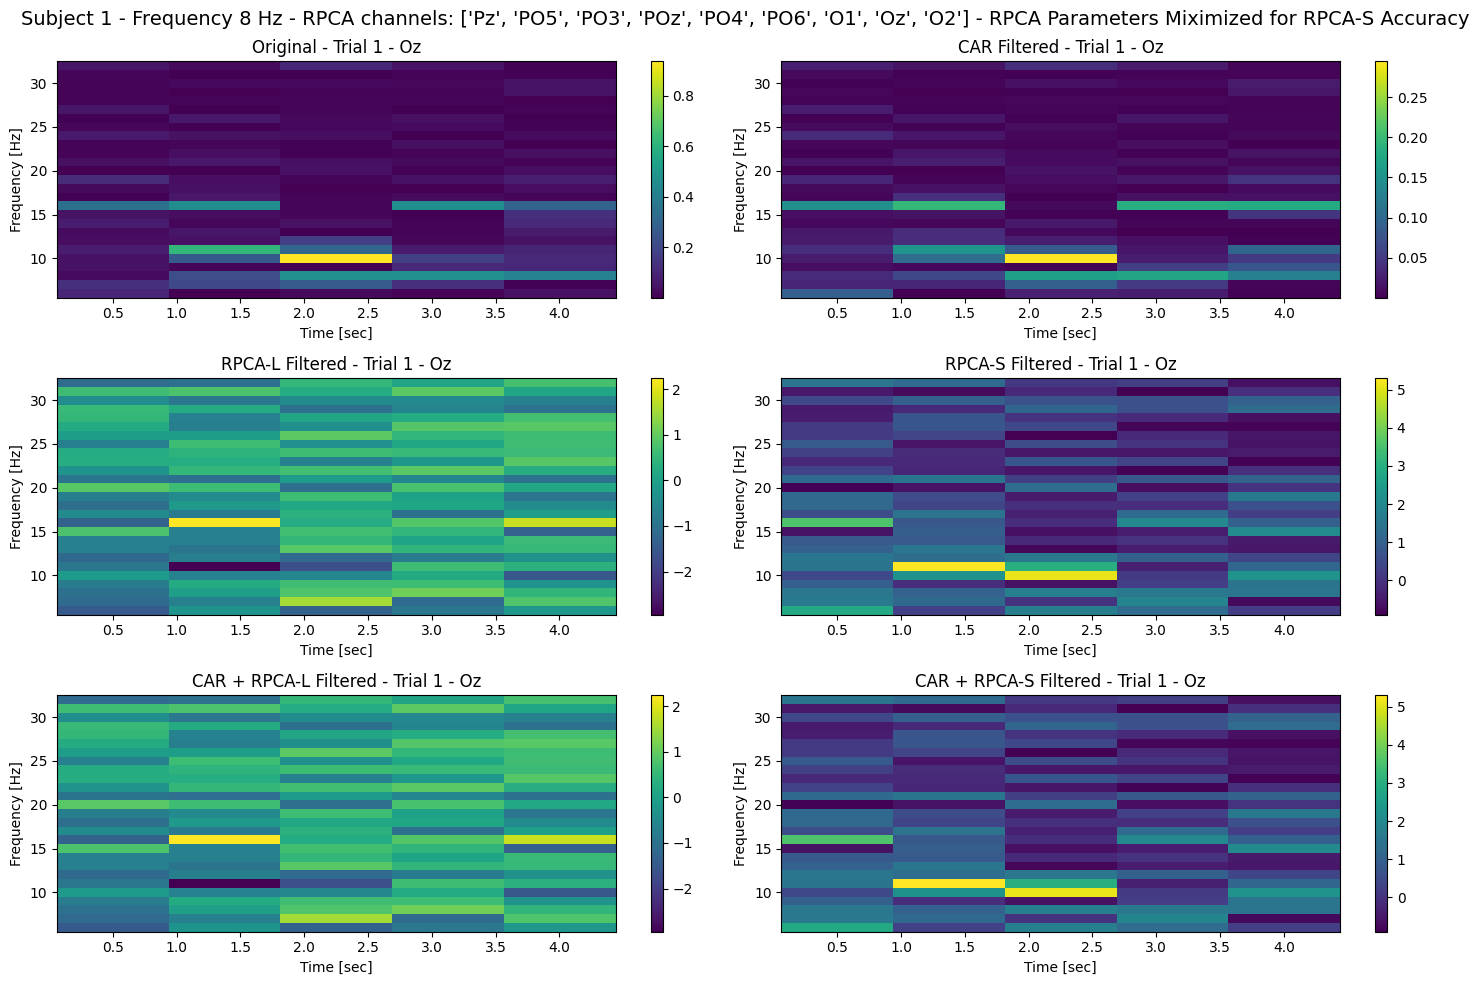

\nGenerating comparison for Trial 2...
Selected channels: {'Pz': 47, 'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([47, 53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_b

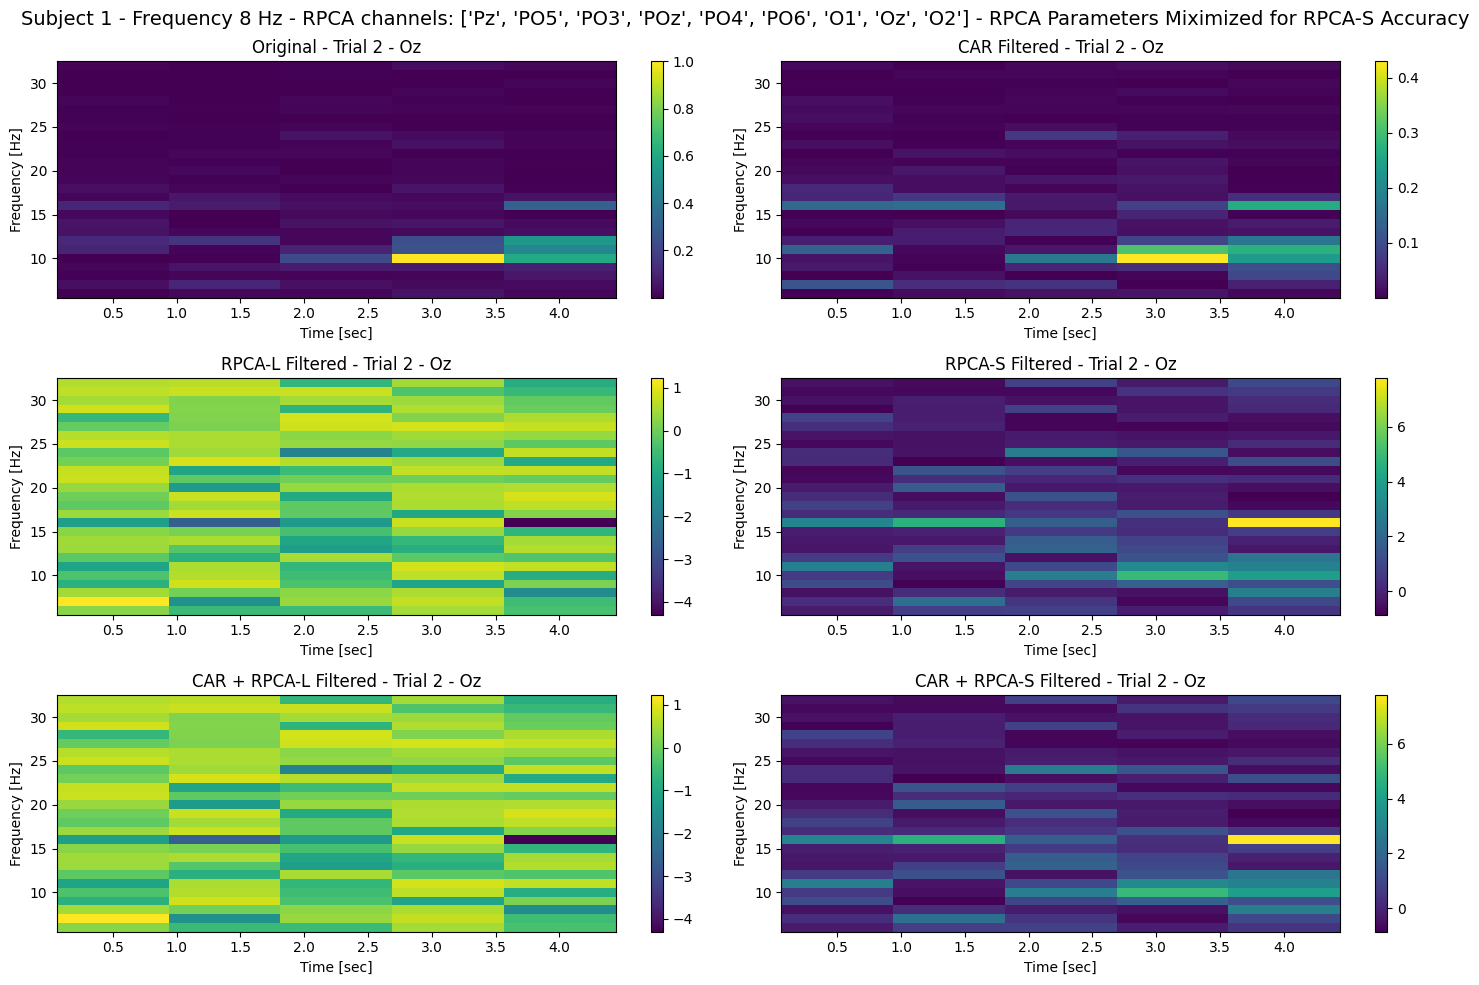

\nGenerating comparison for Trial 3...
Selected channels: {'Pz': 47, 'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([47, 53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_b

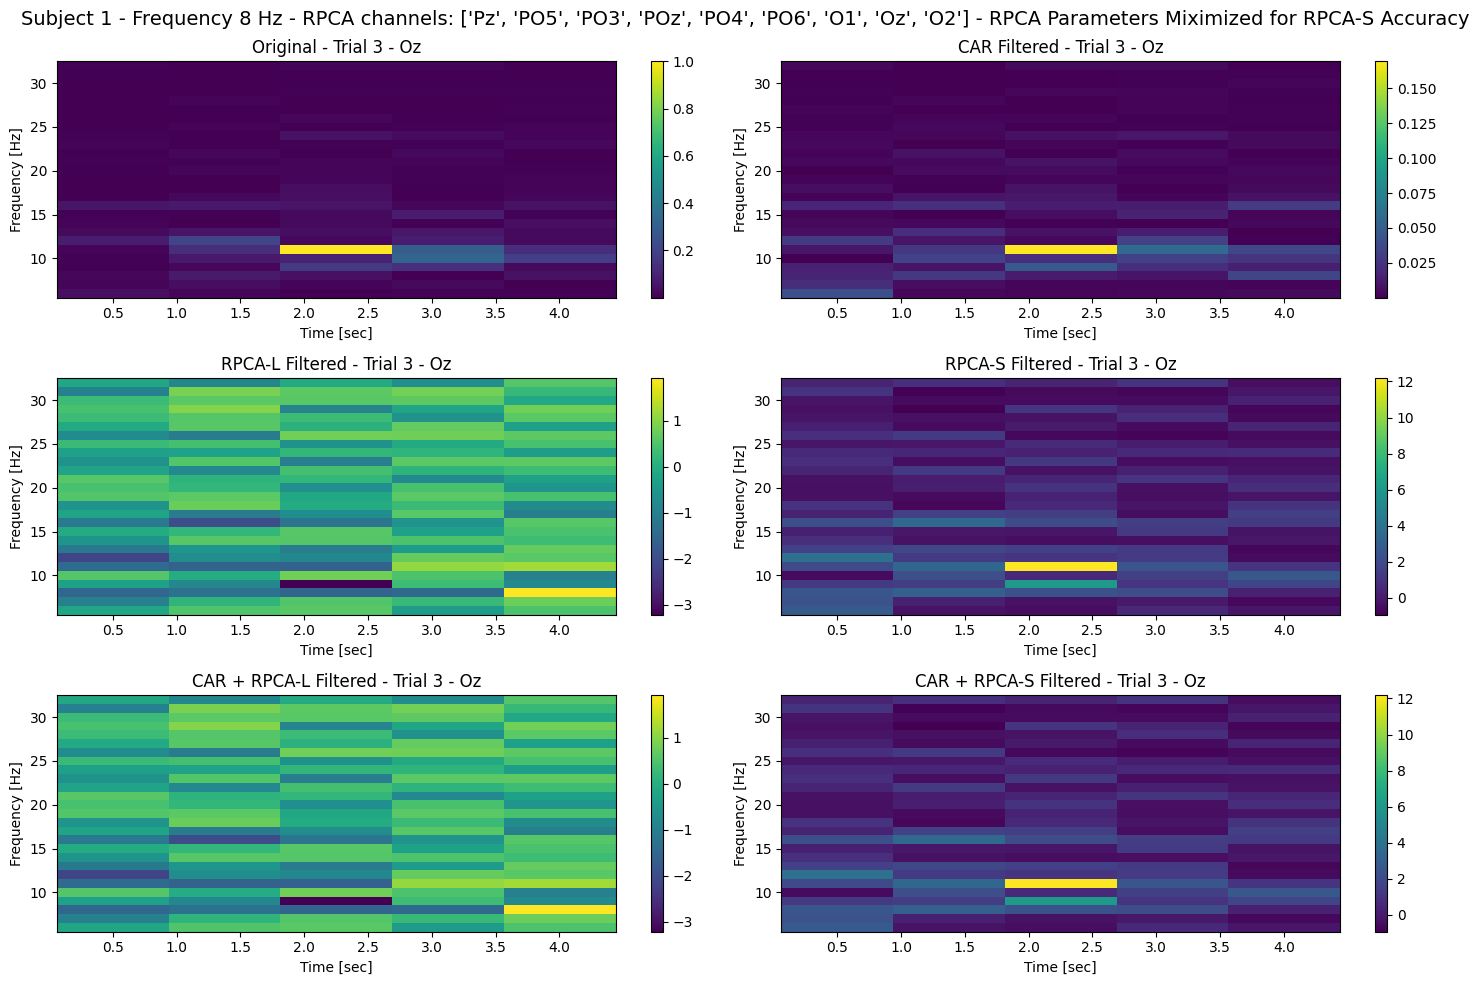

\nGenerating comparison for Trial 4...
Selected channels: {'Pz': 47, 'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([47, 53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_b

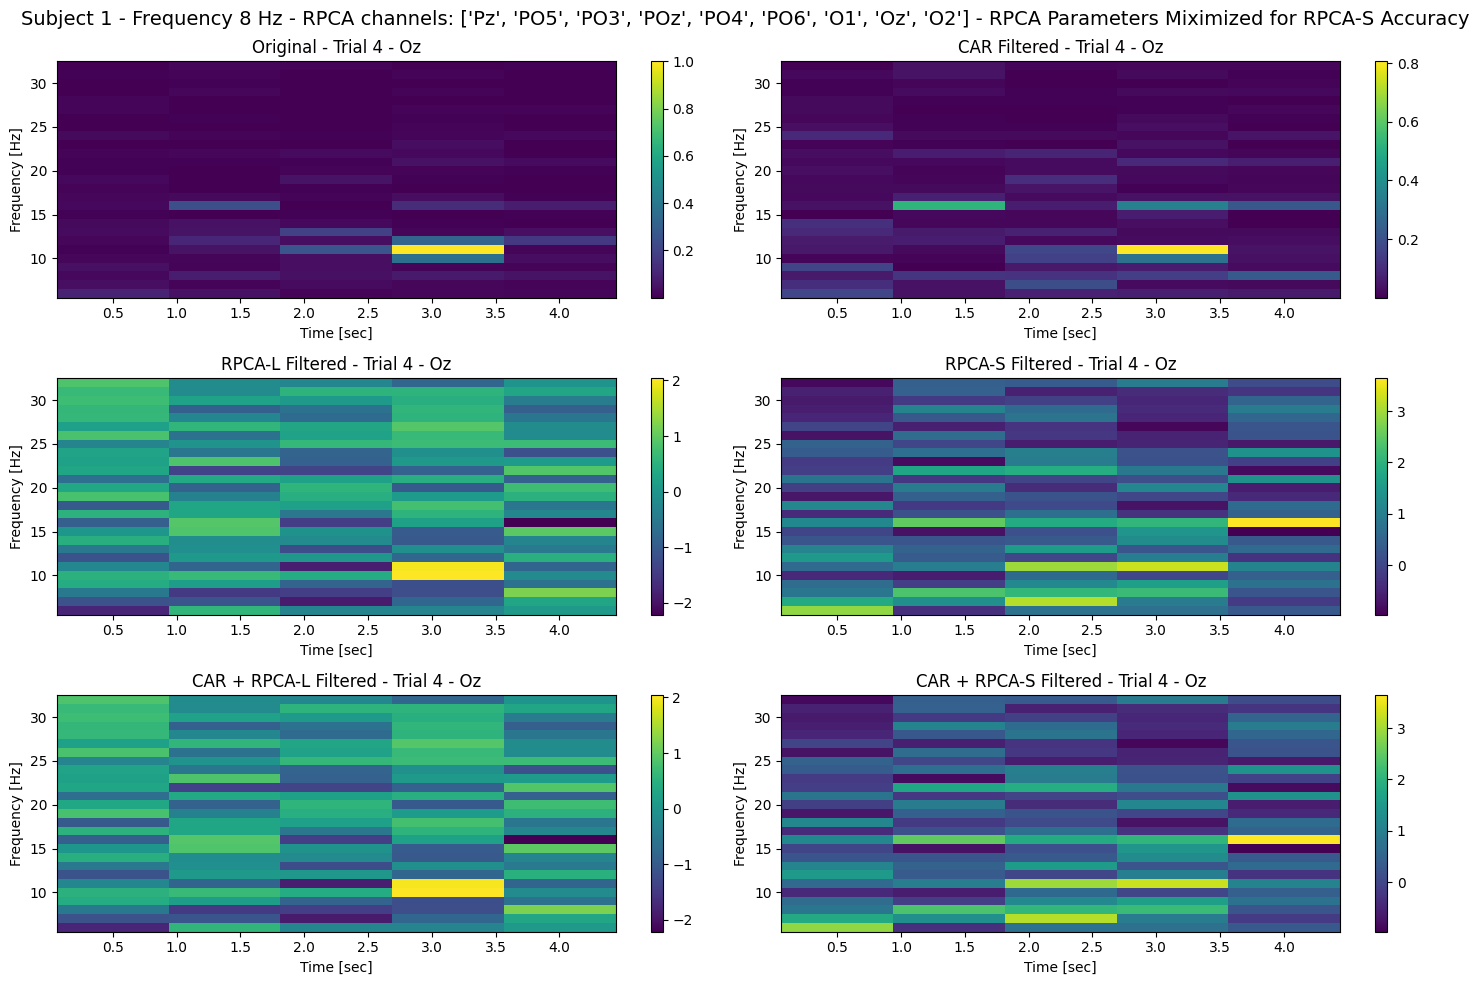

\nGenerating comparison for Trial 5...
Selected channels: {'Pz': 47, 'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([47, 53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_b

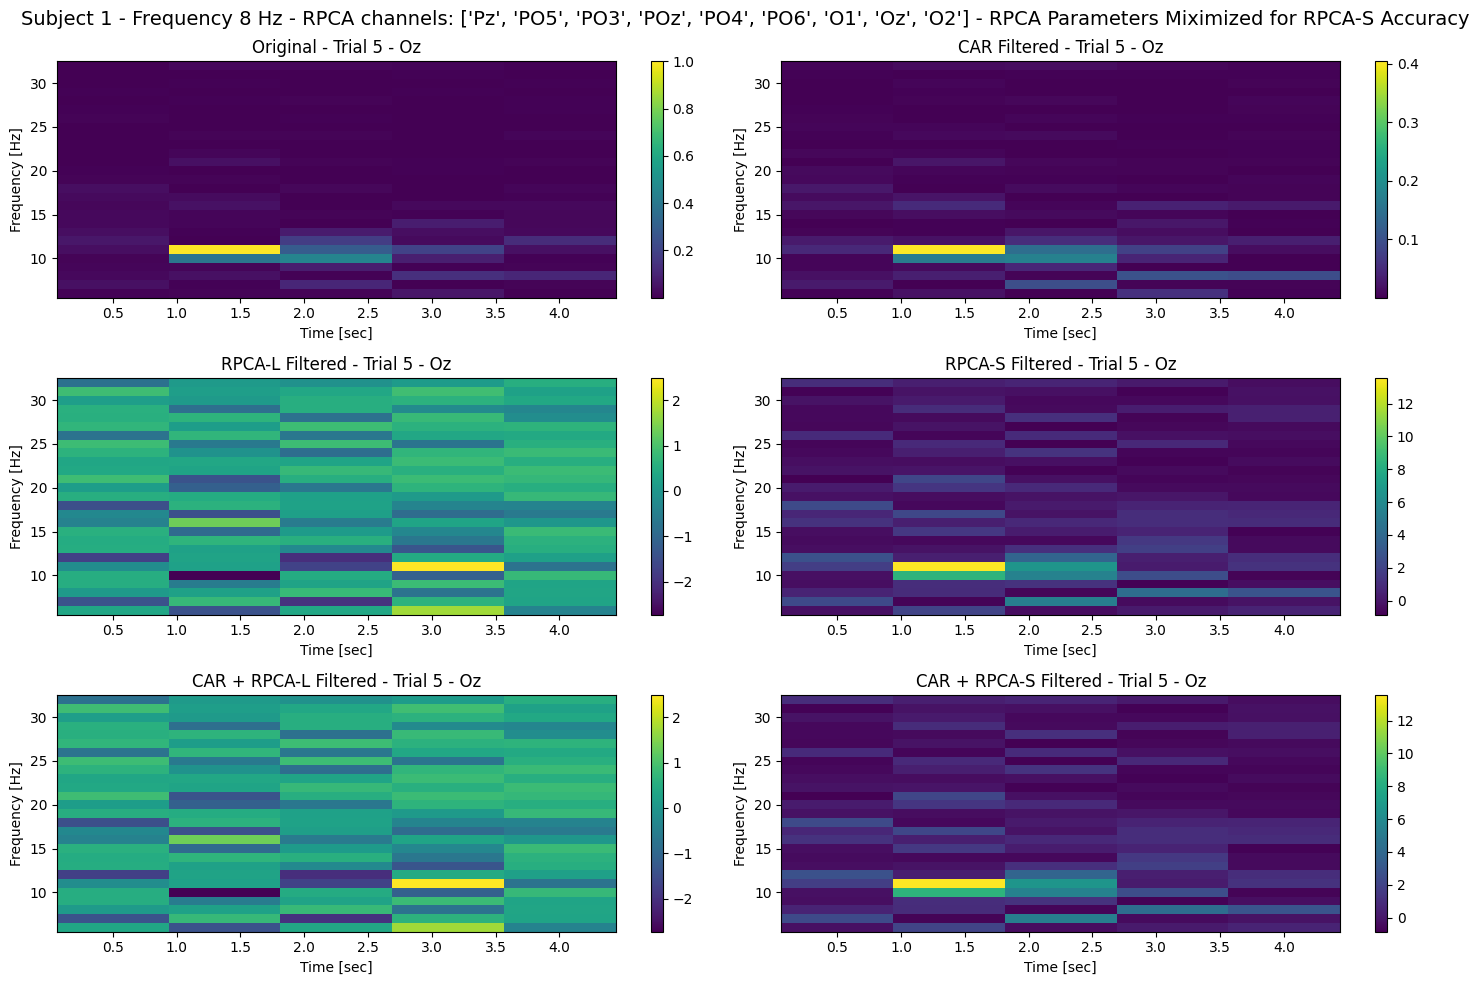

\nGenerating comparison for Trial 6...
Selected channels: {'Pz': 47, 'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([47, 53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_b

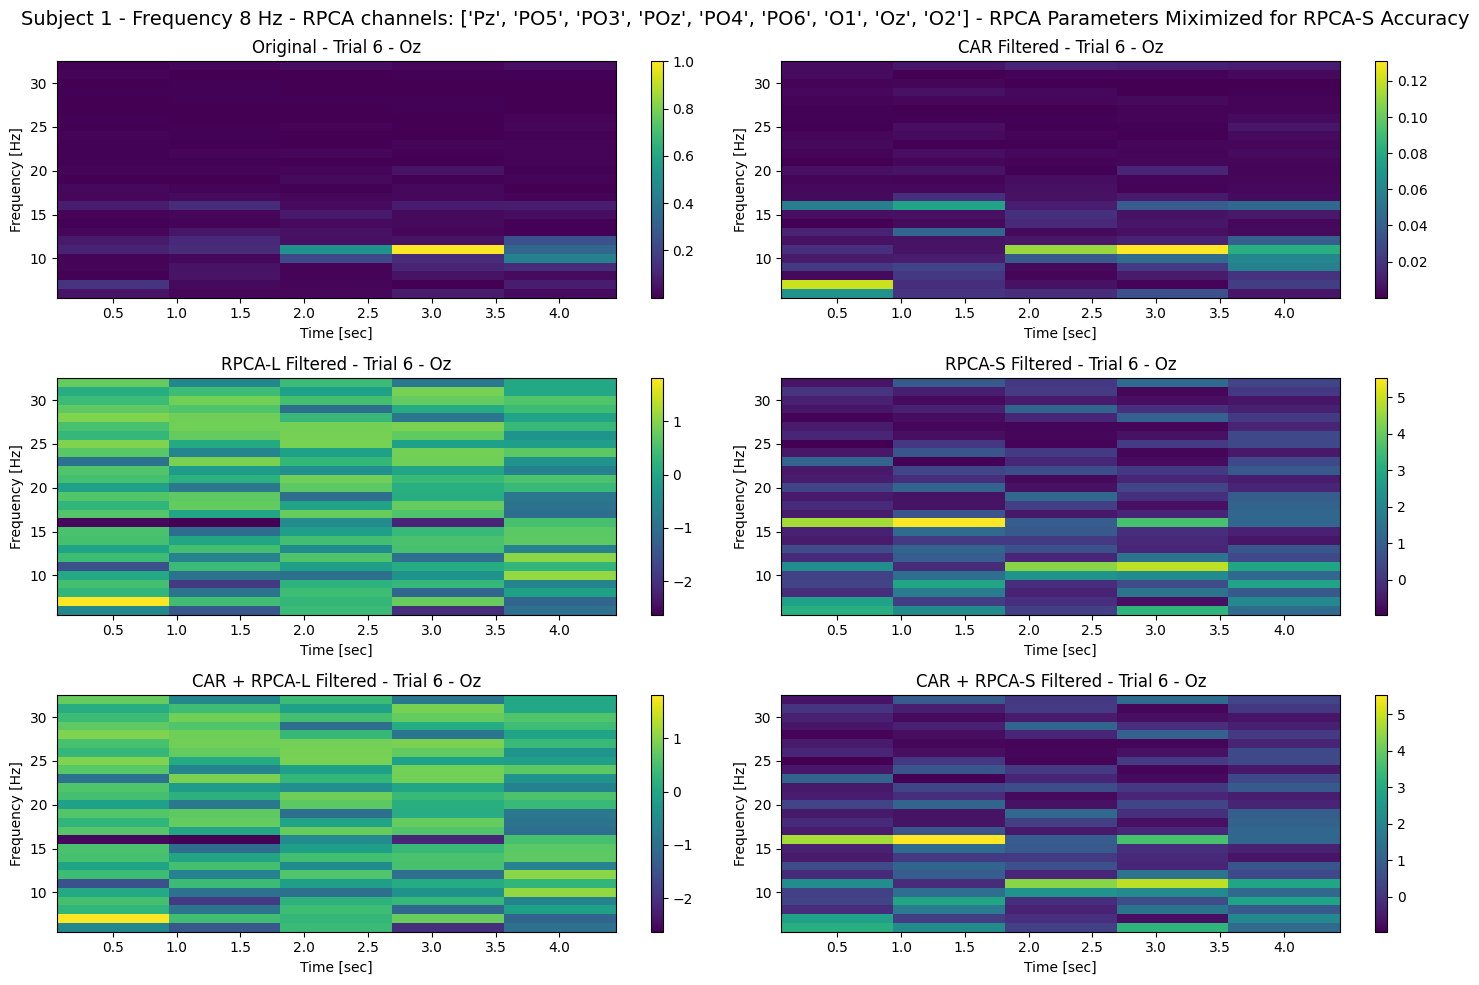

In [34]:
# Generate comparison plots for all trials using optimized parameters
print(f"Generating spectrogram comparisons for all {number_of_trials} trials...")

for subject in range(1, NUM_SUBJECTS+1):
    for trial in range(1, number_of_trials + 1):
        print(f"\\nGenerating comparison for Trial {trial}...")
        plot_spectrogram_comparison(
            eeg_data=eeg_data,
            channel_name=channel_name,
            selected_channels=selected_channels,
            trial=trial,
            frequency=default_evoked_frequency,
            fs=fs,
            start_sample=bci_start_sample,
            end_sample=bci_end_sample,
            lambda_val=best_mu_spectogram_list_by_subject[subject-1][2],
            mu_val=best_mu_spectogram_list_by_subject[subject-1][2],
            nperseg=250,
            subject_id=subject
        )

## Feature Extraction

In [25]:
# Create label representations for classification
# Y_vector: 1D array with class labels (e.g., [0, 1, 2, 0, 1, ...])
Y_vector = get_label_vector(evoked_frequencies)

# Y_matrix: One-hot encoded matrix representation of labels
# (e.g., [[1,-1,-1], [-1,1,-1], [-1,-1,1], [1,-1,-1], ...])
Y_matrix = get_label_matrix(evoked_frequencies)


In [26]:
X_LIST_BY_PREPROCESSING_METHOD_BY_SUBJECT = []

for subject in range(1, NUM_SUBJECTS+1):
    eeg_data = eeg_data_by_subject[subject - 1]
    precompute_all_spectrograms(eeg_data, selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample)

    X_LIST_BY_PREPROCESSING_METHOD = {
        "RPCA_L": None,
        "RPCA_S": None,
        "CAR_RPCA_L": None,
        "CAR_RPCA_S": None
    }

    for i, maximized_for_method in enumerate(preprocessing_methods):
        if maximized_for_method == 'CAR':
            continue
        else:
            best_lamb_spectogram = best_lamb_spectogram_list_by_subject[subject-1][i]
            best_mu_spectogram = best_mu_spectogram_list_by_subject[subject-1][i]

        # Feature extraction from CAR filtered data
        freqs, t, Sxx = get_spectogram_data(apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample)
        X_CAR = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

        # Feature extraction from RPCA low-rank component
        freqs, t, Sxx = get_spectogram_data_rpca_filtered(eeg_data, selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, best_lamb_spectogram, best_mu_spectogram, filter_type='L')
        X_RPCA_L = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

        # Feature extraction from RPCA sparse component
        freqs, t, Sxx = get_spectogram_data_rpca_filtered(eeg_data, selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, best_lamb_spectogram, best_mu_spectogram, filter_type='S')
        X_RPCA_S = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

        precompute_all_spectrograms(apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample)

        # Feature extraction from CAR+RPCA low-rank component
        freqs, t, Sxx = get_spectogram_data_rpca_filtered(apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, best_lamb_spectogram, best_mu_spectogram, filter_type='L')
        X_CAR_RPCA_L = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

        # Feature extraction from CAR+RPCA sparse component
        freqs, t, Sxx = get_spectogram_data_rpca_filtered(apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, best_lamb_spectogram, best_mu_spectogram, filter_type='S')
        X_CAR_RPCA_S = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

        # Make feature matrix list for all preprocessing methods
        # MUST KEEP IN THE SAME ORDER AS THE preprocessing_methods LIST
        X_LIST = [X_CAR, X_RPCA_L, X_RPCA_S, X_CAR_RPCA_L, X_CAR_RPCA_S]

        # Store feature matrix list for each preprocessing method
        X_LIST_BY_PREPROCESSING_METHOD[maximized_for_method] = X_LIST

    X_LIST_BY_PREPROCESSING_METHOD_BY_SUBJECT.append(X_LIST_BY_PREPROCESSING_METHOD)



Precomputing spectrograms for optimization...
Progress: 100/216 spectrograms computed (46.3%)
Progress: 200/216 spectrograms computed (92.6%)
Progress: 216/216 spectrograms computed (100.0%)
✓ Spectrogram cache initialized with 216 precomputed spectrograms
Cache structure: 6 trials × 4 frequencies × 9 channels
Selected channels: {'Pz': 47, 'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([47, 53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel Pz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by

### Train and Validation

In [27]:
X_training_list_by_preprocessing_method_by_subject = []
X_validation_list_by_preprocessing_method_by_subject = []
Y_vector_training_by_preprocessing_method_by_subject = []
Y_vector_validation_by_preprocessing_method_by_subject = []
Y_matrix_training_by_preprocessing_method_by_subject = []
Y_matrix_validation_by_preprocessing_method_by_subject = []

for subject in range(1, NUM_SUBJECTS+1):
    # Split data into training (80%) and validation (20%) sets for each preprocessing method
    # Stratify by Y_vector to ensure balanced class distribution
    X_training_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    X_validation_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_vector_training_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_matrix_training_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_vector_validation_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_matrix_validation_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }

    for maximized_for_method in X_LIST_BY_PREPROCESSING_METHOD_BY_SUBJECT[subject-1].keys():
        X_training_list = []
        X_validation_list = []
        Y_vector_training = []
        Y_vector_validation = []
        Y_matrix_training = []
        Y_matrix_validation = []

        for X in X_LIST_BY_PREPROCESSING_METHOD_BY_SUBJECT[subject-1][maximized_for_method]:
            X_train, X_val, \
            Y_vector_train, Y_vector_val, \
            Y_matrix_train, Y_matrix_val = train_test_split(
                X,
                Y_vector,
                Y_matrix,
                test_size=0.2,
                stratify=Y_vector,
                random_state=42  # For reproducibility
            )
            
            X_training_list.append(X_train)
            X_validation_list.append(X_val)
            Y_vector_training.append(Y_vector_train)
            Y_vector_validation.append(Y_vector_val)
            Y_matrix_training.append(Y_matrix_train)
            Y_matrix_validation.append(Y_matrix_val)

        X_training_list_by_preprocessing_method[maximized_for_method] = X_training_list
        X_validation_list_by_preprocessing_method[maximized_for_method] = X_validation_list
        Y_vector_training_by_preprocessing_method[maximized_for_method] = Y_vector_training
        Y_vector_validation_by_preprocessing_method[maximized_for_method] = Y_vector_validation
        Y_matrix_training_by_preprocessing_method[maximized_for_method] = Y_matrix_training
        Y_matrix_validation_by_preprocessing_method[maximized_for_method] = Y_matrix_validation

    X_training_list_by_preprocessing_method_by_subject.append(X_training_list_by_preprocessing_method)
    X_validation_list_by_preprocessing_method_by_subject.append(X_validation_list_by_preprocessing_method)
    Y_vector_training_by_preprocessing_method_by_subject.append(Y_vector_training_by_preprocessing_method)
    Y_vector_validation_by_preprocessing_method_by_subject.append(Y_vector_validation_by_preprocessing_method)
    Y_matrix_training_by_preprocessing_method_by_subject.append(Y_matrix_training_by_preprocessing_method)
    Y_matrix_validation_by_preprocessing_method_by_subject.append(Y_matrix_validation_by_preprocessing_method)



In [28]:
least_squares_list_by_preprocessing_method_by_subject = []
lda_list_by_preprocessing_method_by_subject = []
svm_list_by_preprocessing_method_by_subject = []
Y_least_squares_pred_list_by_preprocessing_method_by_subject = []
Y_lda_pred_list_by_preprocessing_method_by_subject = []
Y_svm_pred_list_by_preprocessing_method_by_subject = []

for subject in range(1, NUM_SUBJECTS+1):
    least_squares_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    lda_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    svm_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_least_squares_pred_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_lda_pred_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    Y_svm_pred_list_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }

    for maximized_for_method in X_LIST_BY_PREPROCESSING_METHOD_BY_SUBJECT[subject-1].keys():
        # Train models for each preprocessing method
        least_squares_list = []
        lda_list = []
        svm_list = []
        Y_least_squares_pred_list = []
        Y_lda_pred_list = []
        Y_svm_pred_list = []

        X_training_list = X_training_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
        X_validation_list = X_validation_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
        Y_vector_training = Y_vector_training_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
        Y_vector_validation = Y_vector_validation_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
        Y_matrix_training = Y_matrix_training_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
        Y_matrix_validation = Y_matrix_validation_by_preprocessing_method_by_subject[subject-1][maximized_for_method]


        for i, method in enumerate(preprocessing_methods):
            print(f"\nTraining models for {method} preprocessing...")
            
            # Train Least Squares model
            ls = LeastSquares()
            ls.fit(X_training_list[i], Y_matrix_training[i])
            y_ls_pred = ls.predict(X_validation_list[i])
            least_squares_list.append(ls)
            Y_least_squares_pred_list.append(y_ls_pred)
            
            # Train LDA model
            lda_model = LinearDiscriminantAnalysis()
            if np.all(X_training_list[i] != 0):
                lda_model.fit(X_training_list[i], Y_vector_training[i])
                y_lda_pred = lda_model.predict(X_validation_list[i])
            else:
                y_lda_pred = np.zeros(len(X_validation_list[i]))
            lda_list.append(lda_model)
            Y_lda_pred_list.append(y_lda_pred)

            # Train SVM model
            svm_model = SVC(kernel='linear')
            svm_model.fit(X_training_list[i], Y_vector_training[i])
            y_svm_pred = svm_model.predict(X_validation_list[i])
            svm_list.append(svm_model)
            Y_svm_pred_list.append(y_svm_pred)

        least_squares_list_by_preprocessing_method[maximized_for_method] = least_squares_list
        lda_list_by_preprocessing_method[maximized_for_method] = lda_list
        svm_list_by_preprocessing_method[maximized_for_method] = svm_list
        Y_least_squares_pred_list_by_preprocessing_method[maximized_for_method] = Y_least_squares_pred_list
        Y_lda_pred_list_by_preprocessing_method[maximized_for_method] = Y_lda_pred_list
        Y_svm_pred_list_by_preprocessing_method[maximized_for_method] = Y_svm_pred_list
    
    least_squares_list_by_preprocessing_method_by_subject.append(least_squares_list_by_preprocessing_method)
    lda_list_by_preprocessing_method_by_subject.append(lda_list_by_preprocessing_method)
    svm_list_by_preprocessing_method_by_subject.append(svm_list_by_preprocessing_method)
    Y_least_squares_pred_list_by_preprocessing_method_by_subject.append(Y_least_squares_pred_list_by_preprocessing_method)
    Y_lda_pred_list_by_preprocessing_method_by_subject.append(Y_lda_pred_list_by_preprocessing_method)
    Y_svm_pred_list_by_preprocessing_method_by_subject.append(Y_svm_pred_list_by_preprocessing_method)



Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...

Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...

Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...

Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...


In [29]:
from scipy.stats import shapiro, ttest_rel, wilcoxon
# Perform paired t-tests and Wilcoxon comparing each method against the first one (baseline)
def compare_against_baseline(accuracies_array):
    """Compare each preprocessing method against the first one (baseline) using paired t-test and Wilcoxon signed-rank test"""
    baseline = accuracies_array[:, 0]  # First preprocessing method as baseline
    ttest_stats = []
    ttest_pvals = []
    wilcoxon_stats = []
    wilcoxon_pvals = []

    for i in range(accuracies_array.shape[1]):
        if i == 0:
            # Baseline vs itself - no test needed
            ttest_stats.append(np.nan)
            ttest_pvals.append(np.nan)
            wilcoxon_stats.append(np.nan)
            wilcoxon_pvals.append(np.nan)
        else:
            # Compare each method against baseline (paired t-test)
            stat, pval = ttest_rel(baseline, accuracies_array[:, i])
            ttest_stats.append(stat)
            ttest_pvals.append(pval)

            # Wilcoxon signed-rank test
            try:
                w_stat, w_pval = wilcoxon(baseline, accuracies_array[:, i])
            except ValueError:
                # Wilcoxon fails if all differences are zero
                w_stat, w_pval = np.nan, np.nan
            wilcoxon_stats.append(w_stat)
            wilcoxon_pvals.append(w_pval)

    return {
        "ttest_stats": np.array(ttest_stats),
        "ttest_pvals": np.array(ttest_pvals),
        "wilcoxon_stats": np.array(wilcoxon_stats),
        "wilcoxon_pvals": np.array(wilcoxon_pvals)
    }

def store_accuracies():
    subjects_ls_accuracies_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    subjects_lda_accuracies_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }
    subjects_svm_accuracies_by_preprocessing_method = {
        "RPCA_L": [],
        "RPCA_S": [],
        "CAR_RPCA_L": [],
        "CAR_RPCA_S": []
    }

    # Process all subjects for each maximization method
    for i, maximized_for_method in enumerate(["RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]):
        print(f"\nProcessing maximization for method: {maximized_for_method}")
        
        # Collect accuracies for all subjects
        subjects_ls_accuracies = []  # [subject][preprocessing_method]
        subjects_lda_accuracies = []
        subjects_svm_accuracies = []
        
        # Process each subject (data is organized by subject, then by preprocessing method)
        for subject in range(1, NUM_SUBJECTS+1):
            try:
                # Get validation data for this subject and maximized method
                # The data structure is: by_subject[subject-1][preprocessing_method][list_index]
                Y_vector_validation = Y_vector_validation_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
                Y_least_squares_pred_list = Y_least_squares_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
                Y_lda_pred_list = Y_lda_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
                Y_svm_pred_list = Y_svm_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
                
                # Calculate accuracies for each preprocessing method for this subject
                subject_ls_accs = []
                subject_lda_accs = []
                subject_svm_accs = []
                
                for j, method in enumerate(preprocessing_methods):
                    ls_acc = accuracy_score(Y_vector_validation[j], Y_least_squares_pred_list[j])
                    lda_acc = accuracy_score(Y_vector_validation[j], Y_lda_pred_list[j])
                    svm_acc = accuracy_score(Y_vector_validation[j], Y_svm_pred_list[j])
                    
                    subject_ls_accs.append(ls_acc)
                    subject_lda_accs.append(lda_acc)
                    subject_svm_accs.append(svm_acc)

                    if method == 'CAR':
                        print(f"Subject {subject} - {method} - LS: {ls_acc:.4f}, LDA: {lda_acc:.4f}, SVM: {svm_acc:.4f}")
                
                subjects_ls_accuracies.append(subject_ls_accs)
                subjects_lda_accuracies.append(subject_lda_accs)
                subjects_svm_accuracies.append(subject_svm_accs)
                
            except (IndexError, KeyError) as e:
                print(f"Warning: Could not process subject {subject} for method {maximized_for_method}: {e}")
                continue
        
        subjects_ls_accuracies_by_preprocessing_method[maximized_for_method] = subjects_ls_accuracies
        subjects_lda_accuracies_by_preprocessing_method[maximized_for_method] = subjects_lda_accuracies
        subjects_svm_accuracies_by_preprocessing_method[maximized_for_method] = subjects_svm_accuracies

    subjects_all_accuracies_by_preprocessing_method = {
        "Least Squares": subjects_ls_accuracies_by_preprocessing_method,
        "LDA": subjects_lda_accuracies_by_preprocessing_method,
        "SVM": subjects_svm_accuracies_by_preprocessing_method
    }
    pd.DataFrame(subjects_all_accuracies_by_preprocessing_method).to_csv('results/subjects_all_accuracies_by_preprocessing_method_frequency.csv', index=False)
    
def generate_boxplot():
    # -----------------------------------------
    # Unified matplotlib boxplot for all classifiers and preprocessing methods
    # -----------------------------------------

    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines

    # Data layout: preprocessing_methods x classifiers x subjects
    data = [
        subjects_ls_accuracies,   # shape: subjects x methods
        subjects_lda_accuracies,
        subjects_svm_accuracies
    ]  # List of [subjects x methods] arrays

    classifier_names = ['Least Squares', 'LDA', 'SVM']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # For LS, LDA, SVM

    num_methods = len(preprocessing_methods)
    num_classifiers = len(classifier_names)

    fig, ax = plt.subplots(figsize=(16,8))

    box_width = 0.22
    box_distance = 0.08
    total_width = num_classifiers * box_width + (num_classifiers-1)*box_distance
    xs = np.arange(num_methods)

    # Collect boxplot positions and data
    boxplot_data = []
    positions = []
    color_patches = []

    for i, method in enumerate(preprocessing_methods):
        for j, (clf_accs, clf_name) in enumerate(zip(data, classifier_names)):
            # For each classifier for this method, get accuracy for all subjects (the column)
            boxplot_data.append(clf_accs[:,i])
            # Position: spaced within each group
            pos = i - total_width/2 + box_width/2 + j*(box_width+box_distance)
            positions.append(pos)
            if i == 0:
                color_patches.append(mpatches.Patch(color=colors[j], label=clf_name))

    # Draw single combined boxplot using matplotlib
    bp = ax.boxplot(
        boxplot_data,
        positions=positions,
        widths=box_width,
        patch_artist=True,
        showmeans=True,
        meanline=True,
        showfliers=True
    )

    # Color the boxes
    for k, box in enumerate(bp['boxes']):
        classifier_idx = k % num_classifiers
        box.set(facecolor=colors[classifier_idx], alpha=0.7)
    for k, median in enumerate(bp['medians']):
        median.set(color='black', linewidth=2)
    for k, mean in enumerate(bp['means']):
        mean.set(color='red', linewidth=2)
    for k, whisker in enumerate(bp['whiskers']):
        whisker.set(color='grey')
    for k, cap in enumerate(bp['caps']):
        cap.set(color='grey')

    # X-axis: Set ticks at center of each group
    ax.set_xticks(xs)
    ax.set_xticklabels(preprocessing_methods, rotation=45, ha='right', fontsize=12)

    # Y-label and title
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Preprocessing Method', fontsize=14)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.2)

    # Main title and subtitle
    ax.set_title(
        f"Frequency Domain - Accuracy Distribution by Classifier and Preprocessing Method"
        f"\n(N={len(subjects_ls_accuracies)} subjects, {len(selected_channels)} channels, Maximized: {maximized_for_method})",
        fontsize=15, fontweight='bold'
    )

    # Legends for classifier colors, means, and medians
    handles = color_patches.copy()
    # Add legend for mean (red line) and median (black line)
    mean_line = mlines.Line2D([], [], color='red', linewidth=2, label='Mean')
    median_line = mlines.Line2D([], [], color='black', linewidth=2, label='Median')
    handles.extend([mean_line, median_line])

    ax.legend(handles=handles, fontsize=12)
    plt.tight_layout()

    # Save
    plt.savefig(
        f'results/frequency_domain_unified_boxplot_{len(selected_channels)}ch_maximized_for_{maximized_for_method}.png', 
        dpi=300, bbox_inches='tight'
    )
    print(f"Unified boxplot saved to: results/frequency_domain_unified_boxplot_{len(selected_channels)}ch_maximized_for_{maximized_for_method}.png")
    plt.show()
    # -----------------------------------------

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)
store_accuracies()

# Initialize storage for aggregated results across all subjects
aggregated_results = {}

# Initialize a structure to collect all accuracies across subjects
for preprocessing_method in ["RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]:
    aggregated_results[preprocessing_method] = {
        'ls_accuracies': [],  # Will be 2D: [subject][preprocessing_method]
        'lda_accuracies': [],
        'svm_accuracies': [],
        'preprocessing_methods': preprocessing_methods.copy()
    }

selected_subjects_type = "worst"

selected_subjects = {
    "best": [0, 2, 5, 7, 9, 13, 14, 16, 19, 21, 24, 25, 26, 27, 29, 30, 31, 33, 34],
    "worst": [1, 3, 4, 6, 8, 10, 11, 12, 15, 17, 18, 20, 22, 23, 28, 32],
    "all": list(range(NUM_SUBJECTS))
}

selected_plot_title = {
    "best": f'Best Group Aggregated Model Accuracy by Preprocessing Method\n(N_best={len(subjects_ls_accuracies)} subjects, {len(selected_channels)} channels)',
    "worst": f'Worst Group Aggregated Model Accuracy by Preprocessing Method\n(N_worst={len(subjects_ls_accuracies)} subjects, {len(selected_channels)} channels)',
    "all": f'Aggregated Model Accuracy by Preprocessing Method\n(N={len(subjects_ls_accuracies)} subjects, {len(selected_channels)} channels)'
}

selected_file_name = {
    "best": f'best_frequency_domain_aggregated_model_accuracy_by_preprocessing_method_{len(selected_channels)}ch',
    "worst": f'worst_frequency_domain_aggregated_model_accuracy_by_preprocessing_method_{len(selected_channels)}ch',
    "all": f'frequency_domain_aggregated_model_accuracy_by_preprocessing_method_{len(selected_channels)}ch'
}


# Process all subjects for each maximization method
for i, maximized_for_method in enumerate(["RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]):
    print(f"\nProcessing maximization for method: {maximized_for_method}")
    
    # Collect accuracies for all subjects
    subjects_ls_accuracies = []  # [subject][preprocessing_method]
    subjects_lda_accuracies = []
    subjects_svm_accuracies = []
    
    # Process each subject (data is organized by subject, then by preprocessing method)
    for subject in range(1, NUM_SUBJECTS+1):
        try:
            # Get validation data for this subject and maximized method
            # The data structure is: by_subject[subject-1][preprocessing_method][list_index]
            Y_vector_validation = Y_vector_validation_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
            Y_least_squares_pred_list = Y_least_squares_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
            Y_lda_pred_list = Y_lda_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
            Y_svm_pred_list = Y_svm_pred_list_by_preprocessing_method_by_subject[subject-1][maximized_for_method]
            
            # Calculate accuracies for each preprocessing method for this subject
            subject_ls_accs = []
            subject_lda_accs = []
            subject_svm_accs = []
            
            for j, method in enumerate(preprocessing_methods):
                ls_acc = accuracy_score(Y_vector_validation[j], Y_least_squares_pred_list[j])
                lda_acc = accuracy_score(Y_vector_validation[j], Y_lda_pred_list[j])
                svm_acc = accuracy_score(Y_vector_validation[j], Y_svm_pred_list[j])
                
                subject_ls_accs.append(ls_acc)
                subject_lda_accs.append(lda_acc)
                subject_svm_accs.append(svm_acc)

                if method == 'CAR':
                    print(f"Subject {subject} - {method} - LS: {ls_acc:.4f}, LDA: {lda_acc:.4f}, SVM: {svm_acc:.4f}")
            
            subjects_ls_accuracies.append(subject_ls_accs)
            subjects_lda_accuracies.append(subject_lda_accs)
            subjects_svm_accuracies.append(subject_svm_accs)
            
        except (IndexError, KeyError) as e:
            print(f"Warning: Could not process subject {subject} for method {maximized_for_method}: {e}")
            continue
    
    # Convert to numpy arrays for easier computation
    subjects_ls_accuracies = np.array(subjects_ls_accuracies)
    subjects_lda_accuracies = np.array(subjects_lda_accuracies)
    subjects_svm_accuracies = np.array(subjects_svm_accuracies)

    subjects_ls_accuracies = subjects_ls_accuracies[selected_subjects[selected_subjects_type]]
    subjects_lda_accuracies = subjects_lda_accuracies[selected_subjects[selected_subjects_type]]
    subjects_svm_accuracies = subjects_svm_accuracies[selected_subjects[selected_subjects_type]]
    
    # Calculate mean and std across subjects for each preprocessing method
    ls_mean = np.mean(subjects_ls_accuracies, axis=0)
    ls_std = np.std(subjects_ls_accuracies, axis=0)
    ls_shapiro = shapiro(subjects_ls_accuracies, axis=0)
    lda_mean = np.mean(subjects_lda_accuracies, axis=0)
    lda_std = np.std(subjects_lda_accuracies, axis=0)
    lda_shapiro = shapiro(subjects_lda_accuracies, axis=0)
    svm_mean = np.mean(subjects_svm_accuracies, axis=0)
    svm_std = np.std(subjects_svm_accuracies, axis=0)
    svm_shapiro = shapiro(subjects_svm_accuracies, axis=0)
    
    # Store aggregated results
    aggregated_results[maximized_for_method]['ls_mean'] = ls_mean
    aggregated_results[maximized_for_method]['ls_std'] = ls_std
    aggregated_results[maximized_for_method]['ls_shapiro_stat'] = ls_shapiro[0]
    aggregated_results[maximized_for_method]['ls_shapiro_pval'] = ls_shapiro[1]
    aggregated_results[maximized_for_method]['ls_ttest_stat'] = compare_against_baseline(subjects_ls_accuracies)['ttest_stats']
    aggregated_results[maximized_for_method]['ls_ttest_pval'] = compare_against_baseline(subjects_ls_accuracies)['ttest_pvals']
    aggregated_results[maximized_for_method]['ls_wilcoxon_stat'] = compare_against_baseline(subjects_ls_accuracies)['wilcoxon_stats']
    aggregated_results[maximized_for_method]['ls_wilcoxon_pval'] = compare_against_baseline(subjects_ls_accuracies)['wilcoxon_pvals']
    aggregated_results[maximized_for_method]['lda_mean'] = lda_mean
    aggregated_results[maximized_for_method]['lda_std'] = lda_std
    aggregated_results[maximized_for_method]['lda_shapiro_stat'] = lda_shapiro[0]
    aggregated_results[maximized_for_method]['lda_shapiro_pval'] = lda_shapiro[1]
    aggregated_results[maximized_for_method]['lda_ttest_stat'] = compare_against_baseline(subjects_lda_accuracies)['ttest_stats']
    aggregated_results[maximized_for_method]['lda_ttest_pval'] = compare_against_baseline(subjects_lda_accuracies)['ttest_pvals']
    aggregated_results[maximized_for_method]['lda_wilcoxon_stat'] = compare_against_baseline(subjects_lda_accuracies)['wilcoxon_stats']
    aggregated_results[maximized_for_method]['lda_wilcoxon_pval'] = compare_against_baseline(subjects_lda_accuracies)['wilcoxon_pvals']
    aggregated_results[maximized_for_method]['svm_mean'] = svm_mean
    aggregated_results[maximized_for_method]['svm_std'] = svm_std
    aggregated_results[maximized_for_method]['svm_shapiro_stat'] = svm_shapiro[0]
    aggregated_results[maximized_for_method]['svm_shapiro_pval'] = svm_shapiro[1]
    aggregated_results[maximized_for_method]['svm_ttest_stat'] = compare_against_baseline(subjects_svm_accuracies)['ttest_stats']
    aggregated_results[maximized_for_method]['svm_ttest_pval'] = compare_against_baseline(subjects_svm_accuracies)['ttest_pvals']
    aggregated_results[maximized_for_method]['svm_wilcoxon_stat'] = compare_against_baseline(subjects_svm_accuracies)['wilcoxon_stats']
    aggregated_results[maximized_for_method]['svm_wilcoxon_pval'] = compare_against_baseline(subjects_svm_accuracies)['wilcoxon_pvals']
    aggregated_results[maximized_for_method]['num_subjects'] = len(subjects_ls_accuracies)
    
    generate_boxplot()

    # Print summary statistics
    print(f"\nSummary for {maximized_for_method} (N_worst={len(subjects_ls_accuracies)} subjects):")
    for j, method in enumerate(preprocessing_methods):
        print(f"{method}:")
        print(f"  LS: {ls_mean[j]*100:.2f}% ± {ls_std[j]*100:.2f}%")
        print(f"  LDA: {lda_mean[j]*100:.2f}% ± {lda_std[j]*100:.2f}%")
        print(f"  SVM: {svm_mean[j]*100:.2f}% ± {svm_std[j]*100:.2f}%")
    
    # Create aggregated bar chart with error bars
    plt.figure(figsize=(14, 10))
    x = np.arange(len(preprocessing_methods))
    width = 0.25
    
    # Create bars with error bars
    bars_ls = plt.bar(x - width, ls_mean, width, yerr=ls_std, 
                     label='Least Squares', capsize=5, alpha=0.8)
    bars_lda = plt.bar(x, lda_mean, width, yerr=lda_std, 
                      label='LDA', capsize=5, alpha=0.8)
    bars_svm = plt.bar(x + width, svm_mean, width, yerr=svm_std, 
                      label='SVM', capsize=5, alpha=0.8)
    
    # Add mean values above each bar
    for idx, bar in enumerate(bars_ls):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + ls_std[idx] + 0.01, 
                f"{ls_mean[idx]*100:.1f}%", ha='center', va='bottom', fontsize=9, fontweight='bold')
    for idx, bar in enumerate(bars_lda):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + lda_std[idx] + 0.01, 
                f"{lda_mean[idx]*100:.1f}%", ha='center', va='bottom', fontsize=9, fontweight='bold')
    for idx, bar in enumerate(bars_svm):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + svm_std[idx] + 0.01, 
                f"{svm_mean[idx]*100:.1f}%", ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.xlabel('Preprocessing Method', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title(selected_plot_title[selected_subjects_type], fontsize=14)
    plt.suptitle(f'Frequency Domain - Maximized for Method: {maximized_for_method}', fontsize=16, fontweight='bold')
    plt.xticks(x, preprocessing_methods, rotation=45, ha='right')
    plt.ylim(0, min(1.0, np.max([ls_mean + ls_std, lda_mean + lda_std, svm_mean + svm_std]) + 0.1))
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(f'results/{selected_file_name[selected_subjects_type]}.png', 
                dpi=300, bbox_inches='tight')
    print(f"Aggregated accuracy chart saved to results/{selected_file_name[selected_subjects_type]}.png")
    
    # Display the plot
    plt.show()
    
    # Create detailed results DataFrame for this maximization method
    detailed_results = []
    for j, method in enumerate(preprocessing_methods):
        detailed_results.append({
            'Maximized_for_Method': maximized_for_method,
            'Preprocessing_Method': method,
            'LS_Mean': ls_mean[j] * 100,
            'LS_Std': ls_std[j] * 100,
            'LS_Shapiro_Stat': ls_shapiro[0][j],
            'LS_Shapiro_Pval': ls_shapiro[1][j],
            'LS_Ttest_Stat': compare_against_baseline(subjects_ls_accuracies)['ttest_stats'][j],
            'LS_Ttest_Pval': compare_against_baseline(subjects_ls_accuracies)['ttest_pvals'][j],
            'LS_Wilcoxon_Stat': compare_against_baseline(subjects_ls_accuracies)['wilcoxon_stats'][j],
            'LS_Wilcoxon_Pval': compare_against_baseline(subjects_ls_accuracies)['wilcoxon_pvals'][j],
            'LDA_Mean': lda_mean[j] * 100,
            'LDA_Std': lda_std[j] * 100,
            'LDA_Shapiro_Stat': lda_shapiro[0][j],
            'LDA_Shapiro_Pval': lda_shapiro[1][j],
            'LDA_Ttest_Stat': compare_against_baseline(subjects_lda_accuracies)['ttest_stats'][j],
            'LDA_Ttest_Pval': compare_against_baseline(subjects_lda_accuracies)['ttest_pvals'][j],
            'LDA_Wilcoxon_Stat': compare_against_baseline(subjects_lda_accuracies)['wilcoxon_stats'][j],
            'LDA_Wilcoxon_Pval': compare_against_baseline(subjects_lda_accuracies)['wilcoxon_pvals'][j],
            'SVM_Mean': svm_mean[j] * 100,
            'SVM_Std': svm_std[j] * 100,
            'SVM_Shapiro_Stat': svm_shapiro[0][j],
            'SVM_Shapiro_Pval': svm_shapiro[1][j],
            'SVM_Ttest_Stat': compare_against_baseline(subjects_svm_accuracies)['ttest_stats'][j],
            'SVM_Ttest_Pval': compare_against_baseline(subjects_svm_accuracies)['ttest_pvals'][j],
            'SVM_Wilcoxon_Stat': compare_against_baseline(subjects_svm_accuracies)['wilcoxon_stats'][j],
            'SVM_Wilcoxon_Pval': compare_against_baseline(subjects_svm_accuracies)['wilcoxon_pvals'][j],
            'Num_Subjects': len(subjects_ls_accuracies)
        })
    
    # Save detailed results to CSV for this maximization method
    detailed_df = pd.DataFrame(detailed_results)
    csv_filename = f'results/{selected_file_name[selected_subjects_type]}.csv'
    detailed_df.to_csv(csv_filename, index=False)
    print(f"Detailed results saved to {csv_filename}")

# Create a comprehensive summary DataFrame combining all maximization methods
all_results = []
for maximized_method, results in aggregated_results.items():
    if 'ls_mean' in results:  # Check if processing was successful
        for j, preprocessing_method in enumerate(results['preprocessing_methods']):
            all_results.append({
                'Maximized_for_Method': maximized_method,
                'Preprocessing_Method': preprocessing_method,
                'LS_Mean': results['ls_mean'][j] * 100,
                'LS_Std': results['ls_std'][j] * 100,
                'LS_Shapiro_Stat': results['ls_shapiro_stat'][j],
                'LS_Shapiro_Pval': results['ls_shapiro_pval'][j],
                'LS_Ttest_Stat': results['ls_ttest_stat'][j],
                'LS_Ttest_Pval': results['ls_ttest_pval'][j],
                'LS_Wilcoxon_Stat': results['ls_wilcoxon_stat'][j],
                'LS_Wilcoxon_Pval': results['ls_wilcoxon_pval'][j],
                'LDA_Mean': results['lda_mean'][j] * 100,
                'LDA_Std': results['lda_std'][j] * 100,
                'LDA_Shapiro_Stat': results['lda_shapiro_stat'][j],
                'LDA_Shapiro_Pval': results['lda_shapiro_pval'][j],
                'LDA_Ttest_Stat': results['lda_ttest_stat'][j],
                'LDA_Ttest_Pval': results['lda_ttest_pval'][j],
                'LDA_Wilcoxon_Stat': results['lda_wilcoxon_stat'][j],
                'LDA_Wilcoxon_Pval': results['lda_wilcoxon_pval'][j],
                'SVM_Mean': results['svm_mean'][j] * 100,
                'SVM_Std': results['svm_std'][j] * 100,
                'SVM_Shapiro_Stat': results['svm_shapiro_stat'][j],
                'SVM_Shapiro_Pval': results['svm_shapiro_pval'][j],
                'SVM_Ttest_Stat': results['svm_ttest_stat'][j],
                'SVM_Ttest_Pval': results['svm_ttest_pval'][j],
                'SVM_Wilcoxon_Stat': results['svm_wilcoxon_stat'][j],
                'SVM_Wilcoxon_Pval': results['svm_wilcoxon_pval'][j],
                'Num_Subjects': results['num_subjects']
            })

# Save comprehensive results
if all_results:
    comprehensive_df = pd.DataFrame(all_results)
    comprehensive_df.to_csv(f'results/comprehensive_{selected_file_name[selected_subjects_type]}.csv', index=False)
    print(f"\nComprehensive results saved to results/comprehensive_{selected_file_name[selected_subjects_type]}.csv")
    
    # Display summary table
    print("\n" + "="*100)
    print("COMPREHENSIVE SUMMARY - MEAN ± STD ACCURACIES (%)")
    print("="*100)
    print(comprehensive_df.to_string(index=False, float_format='%.2f'))

print(f"\n✅ Processing complete! Generated aggregated results for all maximization methods.")



Processing maximization for method: RPCA_L
Subject 1 - CAR - LS: 0.4167, LDA: 0.3750, SVM: 0.5417

Processing maximization for method: RPCA_S
Subject 1 - CAR - LS: 0.4167, LDA: 0.3750, SVM: 0.5417

Processing maximization for method: CAR_RPCA_L
Subject 1 - CAR - LS: 0.4167, LDA: 0.3750, SVM: 0.5417

Processing maximization for method: CAR_RPCA_S
Subject 1 - CAR - LS: 0.4167, LDA: 0.3750, SVM: 0.5417


NameError: name 'subjects_ls_accuracies' is not defined